In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.distributions.multivariate_normal import MultivariateNormal
import random
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Callable, Type, Any
from IPython.display import clear_output

from PPO import FifoList, BatchSampler, RollingBatchSampler 
from PPO import EpisodicSampler, DataBuffer, Optimizer
# from PPO import ModelPerceptron, ParallelPerceptrons
from PPO import Critic, GaussianPDFModel, Policy

import mlflow

In [2]:
class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        simulator,
        policy: Policy,
        critic: Critic,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (InvertedPendulumSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running costs. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_cost, total_cost. Defaults to lambda*args:False
        """

        self.simulator = simulator
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor
        self.data_buffer = DataBuffer()
        self.critic = critic
        self.total_cost = 0
        self.total_costs_episodic = []
        self.learning_curve = []
        self.last_observations = None

    def run(self) -> None:
        """Run main loop"""

        eps = 0.1
        means_total_costs = [eps]
        self.last_observation_interations = []
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            for episode_idx in tqdm(range(self.N_episodes)):
                terminated = False
                while self.simulator.step():
                    (
                        observation,
                        action,
                        step_idx,
                        running_cost
                    ) = self.simulator.get_sim_step_data()

                    new_action = (
                        self.policy.model.sample(torch.tensor(observation).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    discounted_running_cost = (
                        self.discount_factor ** (step_idx) * running_cost
                    )
                    self.total_cost += discounted_running_cost

                    if not terminated and self.termination_criterion(
                        observation,
                        new_action,
                        discounted_running_cost,
                        self.total_cost,
                    ):
                        terminated = True

                    # print("Observation: ", observation.shape)
                    
                    if not terminated:
                        self.data_buffer.push_to_end(
                            observation=np.copy(observation[None, :, :, :]),
                            action=np.copy(new_action),
                            # observation_action=np.hstack((observation, action)),
                            running_cost=np.copy(running_cost),
                            discounted_running_cost=np.copy(discounted_running_cost),
                            total_cost=np.copy(self.total_cost),
                            step_id=step_idx,
                            episode_id=episode_idx,
                        )
                    self.simulator.receive_action(new_action)
                last_observation = np.copy(observation[0, :, :])
                self.simulator.reset()
                self.total_costs_episodic.append(self.total_cost)
                self.total_cost = 0
            self.learning_curve.append(np.mean(self.total_costs_episodic))

            self.last_actions = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["action"]),
            )

            mlflow.log_metric('Cost', np.mean(self.total_costs_episodic), step=iteration_idx)

            if iteration_idx % 10 == 0:
                fig_observation, ax_observation = plt.subplots(1)
                ax_observation.imshow(last_observation)
                ax_observation.set_title(f'Observation, it = {iteration_idx}, cost = {running_cost}')
                mlflow.log_figure(fig_observation, f'observation_{iteration_idx}.png')
                
            self.critic.fit(self.data_buffer)
            self.policy.fit(self.data_buffer)

            means_total_costs.append(np.mean(self.total_costs_episodic))
            change = (means_total_costs[-1] / means_total_costs[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_costs[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}",
                end="\n",
            )

            # --------------------------------------------------------------------------------------
            # Uncomment these lines if you want to stop the simulation when your system is stabilized
            # if self.get_grade() == 100:
            #     return
            # --------------------------------------------------------------------------------------

            self.total_costs_episodic = []

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        # plt.yscale("log")
        plt.show()

        x_c_ax, y_c_ax, a_ax, b_ax = pd.DataFrame(
            data=self.last_actions.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Actions in last iteration",
            legend=False,
            subplots=True,
            grid=True,
        )
        x_c_ax.set_ylabel("X center")
        y_c_ax.set_ylabel("Y center")
        a_ax.set_ylabel("Width")
        b_ax.set_ylabel("Hight")

        plt.show()

    def return_plots(self):
        
        fig_actions_li, ax_li = plt.subplots(4)
        data_actions = self.last_actions.loc[0].values
        # print(data_actions.shape)
        steps = np.arange(len(data_actions))
        ax_li[0].plot(steps, data_actions[:, 0])
        ax_li[0].set_ylabel("X center")
        ax_li[0].set_title("Actions in last iterations")

        ax_li[1].plot(steps, data_actions[:, 1], c='orange')
        ax_li[1].set_ylabel("Y_center")

        ax_li[2].plot(steps, data_actions[:, 2], c='green')
        ax_li[2].set_ylabel("Width")

        ax_li[3].plot(steps, data_actions[:, 3], c='black')
        ax_li[3].set_ylabel("Hight")
        ax_li[3].set_xlabel("Step Number")

        fig_costs, ax_cost = plt.subplots(1)
        
        iterations = np.arange(len(self.learning_curve))

        ax_cost.plot(iterations, self.learning_curve)

        
        ax_cost.set_title("Total cost by iteration")
        ax_cost.set_xlabel("Iteration number")
        ax_cost.set_ylabel("Total cost")
        

        return fig_actions_li, fig_costs
        


In [3]:
class PressGame:
    def __init__(self, n=16):
        self.n_size = n
        self.observation = torch.zeros((2, self.n_size, self.n_size))
        self.observation[0, :, :] = 1
        self.observation[0, self.n_size//2:, 0:self.n_size//2] = 0
        self.action = [0, 0, 0, 0]
        self.step_idx = 0
        self.cost = 0

    def reset(self):
        self.observation[1, :, :] = 0
        self.action = [0, 0, 0, 0]
        self.step_idx = 0
        self.cost = 0
        
    def step(self):
        # print(self.action)
        if self.step_idx < 100:
            x_c, y_c, a, b = self.action[0], self.action[1], self.action[2], self.action[3]
             
            x_1 = x_c - a/2
            x_2 = x_c + a/2
            y_1 = y_c - b/2
            y_2 = y_c + b/2
    
            cut_indeces = torch.clamp(torch.tensor([x_1, x_2, y_1, y_2]), 0, 1)*self.n_size
            cut_indeces = cut_indeces.to(int)
            self.observation[1, cut_indeces[2]:cut_indeces[3], cut_indeces[0]:cut_indeces[1]] = 1
            self.compute_cost()
            self.step_idx += 1

            return True
        else:
            return False
                                  
    def compute_cost(self):
        cost_space = 2*self.observation[0, :, :] + self.observation[1, :, :]
        positive_cost = (cost_space == 1).sum()*(0)
        negative_cost = (cost_space == 3).sum()*(100)

        self.cost = positive_cost + negative_cost

    def receive_action(self, new_action):
        self.action = new_action

    def get_sim_step_data(self):
        output_observation = (self.observation[0, :, :] - 0.5) + 0.5*self.observation[1, :, :]
        return (output_observation[None, :, :], self.action, self.step_idx, self.cost)
        

In [4]:
import torch.nn as nn

class CNN_critic(nn.Module):
    def __init__(self,
                 dim_input: int,
                 dim_output: int,
                ):
        super().__init__()
        self.dim_input = dim_input
        self.dim_output = dim_output

        # out_s = (in_s +2*padding - 1*(k - 1) - 1)/stride + 1

        self.model = nn.Sequential(
            # 16 x 16 x 2 -> 8 x 8 x 32
            nn.Conv2d(self.dim_input, 32, kernel_size = 4, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding=1), # 8 x 8 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size = 3, padding=1), # 8 x 8 x 64
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8*8*64, 512),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(512, 64),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(64, self.dim_output),
            # nn.Sigmoid()
        )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # print(x.shape)
        if x.dim() == 3:
            x = x[None, :, :, :]
            output = self.model(x)[0]
        elif x.dim() == 5:
            x = torch.squeeze(x)
            # print(x.shape)
            # print(x.shape)
            # print(self.model(x))
            output =  self.model(x) 
        else:
            output = self.model(x)

        # print(output.shape)
        return output
        # return self.model(x)[0]

class CNN_policy(nn.Module):
    def __init__(self,
                 dim_input: int,
                 dim_output: int,
                ):
        super().__init__()
        self.dim_input = dim_input
        self.dim_output = dim_output

        # out_s = (in_s +2*padding - 1*(k - 1) - 1)/stride + 1

        self.model = nn.Sequential(
            # 16 x 16 x 2 -> 8 x 8 x 32
            nn.Conv2d(self.dim_input, 32, kernel_size = 4, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding=1), # 8 x 8 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size = 3, padding=1), # 8 x 8 x 64
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8*8*64, 512),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(512, 64),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(64, self.dim_output),
            nn.Sigmoid()
        )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # print(x.shape)
        if x.dim() == 3:
            x = x[None, :, :, :]
            output = self.model(x)[0]
        elif x.dim() == 5:
            # print(x.shape)
            x = torch.squeeze(x)
            x = x[:, None, :, :]
            # print(x.shape)
            # print(x.shape)
            # print(self.model(x))
            output =  self.model(x) 
        else:
            output = self.model(x)

        # print(output.shape)
        return output
            

In [6]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

## DO NOT CHANGE THE PARAMS OF SIMULATOR.
simulator = PressGame()
# ---------------------------------------------------------------------------
# YOUR CODE GOES HERE
discount_factor = 0.999  # you can change it, but it is not recommended
# ---------------------------------------------------------------------------
# parameters = {"std": [0.05, 0.1, 0.2, 0.3],
#              "critic_opt_lr": [0.00001, 0.0001, 0.0005, 0.001, 0.005],
#              "critic_opt_epoches": [10, 15, 20, 25, 30],
#              "N_episodes": [2, 3, 4, 5, 6],
#              "td_n": [2, 3, 4, 5, 6],
#              "policy_opt_lr": [0.00001, 0.0001, 0.0005, 0.001, 0.005],
#              "policy_opt_epoches": [10, 15, 20, 25, 30]
#              }



def run_param(ex_id, args):

    np.random.seed(SEED)
    torch.manual_seed(SEED)
    random.seed(SEED)

    gauss_row_model = CNN_policy(
        dim_input = 1, #################################################
        dim_output = 4
    )
    
    
    model = GaussianPDFModel( ### FIXME
        dim_action=4,
        nn_model = gauss_row_model,
        action_bounds=np.array([[0, 1], [0, 1], [0, 1], [0, 1]]),
        # ---------------------------------------------------------------------------
        # YOUR CODE GOES HERE
        scale_factor = 1,
        std=args["std"],  # TRY TO FIND std EMPIRICALLY
        # ---------------------------------------------------------------------------
    )
    critic_model = CNN_critic(
        dim_input=1 , #####################################################
        dim_output=1,
    )
    
    critic_optimizer = Optimizer(
        model=critic_model,
        opt_method=torch.optim.Adam,
        # ---------------------------------------------------------------------------
        # YOUR CODE GOES HERE
        opt_options=dict(lr=args["critic_opt_lr"]),  # TRY TO FIND lr EMPIRICALLY
        n_epochs=args["critic_opt_epoches"],  # TRY TO FIND n_epochs EMPIRICALLY
        # ---------------------------------------------------------------------------
        is_reinstantiate_optimizer=True,  # we reinstantiate optimizer before every
        # optimization procedure to guarantee
        # that Adam doesn't remeber previous gradients
    )
    
    critic = Critic(
        # ---------------------------------------------------------------------------
        # YOUR CODE GOES HERE
        td_n=args["td_n"],  # TRY TO FIND td_n EMPIRICALLY
        # ---------------------------------------------------------------------------
        discount_factor=discount_factor,
        device="cpu",
        model=critic_model,
        optimizer=critic_optimizer,
    )
    
    
    policy_optimizer = Optimizer(
        model=model,
        opt_method=torch.optim.Adam,
        # ---------------------------------------------------------------------------
        # YOUR CODE GOES HERE
        opt_options=dict(lr=args["policy_opt_lr"]),  # TRY TO FIND lr EMPIRICALLY
        n_epochs=args["policy_opt_epoches"], # TRY TO FIND n_epochs EMPIRICALLY
        # ---------------------------------------------------------------------------
        is_reinstantiate_optimizer=True,
    )
    
    policy = Policy(
        model,
        policy_optimizer,
        critic=critic,
        device="cpu",
        discount_factor=discount_factor,
        # ---------------------------------------------------------------------------
        # YOUR CODE GOES HERE
        epsilon=0.2,  # authors advice using 0.2, but you can change it
        # --------------------------------------------------------------------------
    )
    
    
    # This termination criterion never terminates episodes
    trivial_terminantion_criterion = lambda *args: False
    
    scenario = MonteCarloSimulationScenario(
        simulator=simulator,
        policy=policy,
        critic=critic,
        # ---------------------------------------------------------------------------
        # YOUR CODE GOES HERE
        N_episodes=args["N_episodes"],  # Increasing the number of episodes stabilizes learning
        N_iterations=300,  # You can change the number of iterations if you want
        # ---------------------------------------------------------------------------
        termination_criterion=trivial_terminantion_criterion,
        discount_factor=discount_factor,
    )
    
    # defining a new experiment
    experiment_name = 'ppo_press_game_3'
    exp_id = mlflow.set_experiment(experiment_name=experiment_name)
    
    with mlflow.start_run(run_name=ex_id):
        # Logging params and metrics to MLFlow
        mlflow.log_param('model_std', model.std)
        mlflow.log_param('critic_optimizer_lr', critic_optimizer.opt_options["lr"])
        mlflow.log_param('critic_optimizer_n_epochs', critic_optimizer.n_epochs)
        mlflow.log_param('critic_td_n', critic.td_n)
        mlflow.log_param('policy_optimizer_lr', policy_optimizer.opt_options["lr"])
        mlflow.log_param('policy_optimizer_n_epoches', policy_optimizer.n_epochs)
        mlflow.log_param('discount_factor', discount_factor)
        mlflow.log_param('scenario_N_episodes', scenario.N_episodes)
        mlflow.log_param('scenario_N_iterations', scenario.N_iterations)
        
        try:
            scenario.run()
        except KeyboardInterrupt:
            clear_output(wait=True)
            # scenario.plot_data()
    
        fig_actions, fig_cost = scenario.return_plots()
        mlflow.log_figure(fig_actions, 'actions.png')
        mlflow.log_figure(fig_cost, 'cost.png')
    
        # get plots
        # mlflow.log_metric('rmse_train', rmse_train)
        
        # clear_output(wait=True)
        scenario.plot_data()

  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.18it/s]


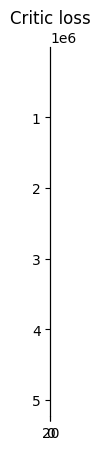

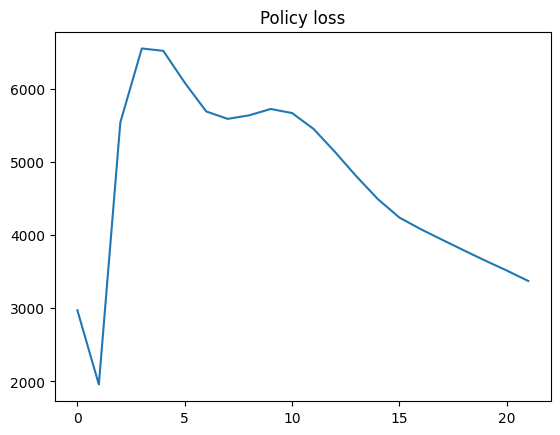

Iteration: 291 / 300, mean total cost 555090.8125, % change: -8.57


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.29it/s]


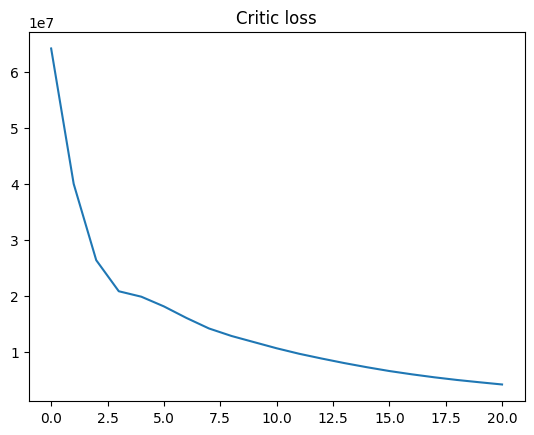

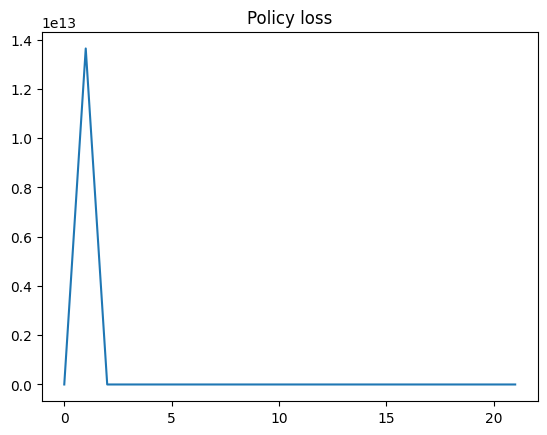

Iteration: 292 / 300, mean total cost 368003.53125, % change: -33.7


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.49it/s]


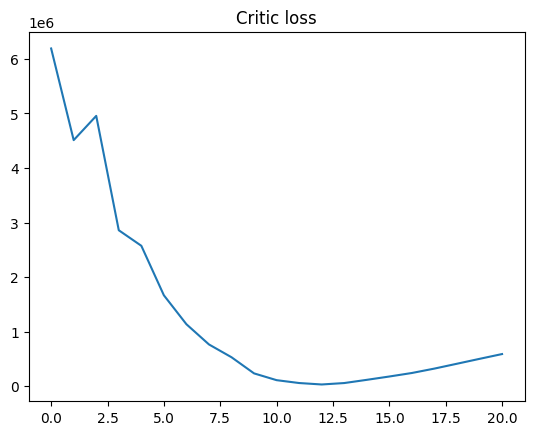

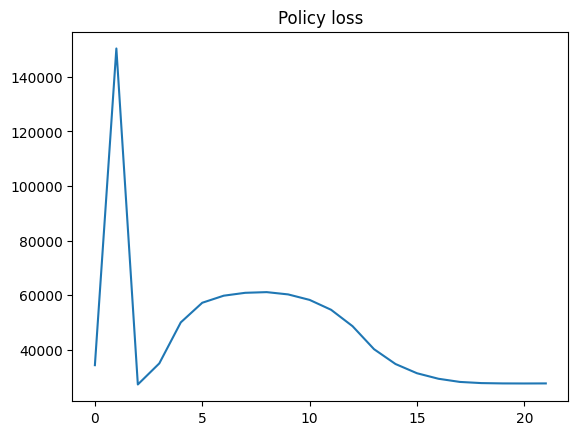

Iteration: 293 / 300, mean total cost 716676.25, % change: +94.75


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.04it/s]


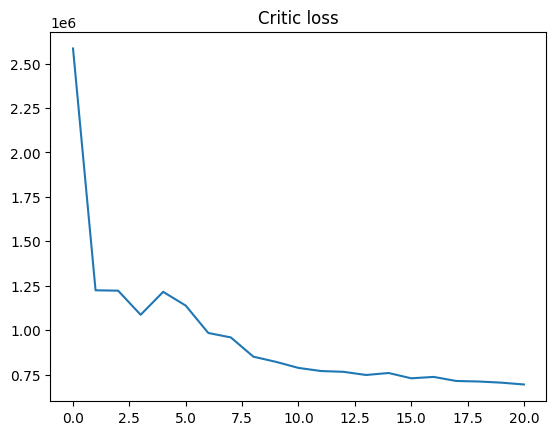

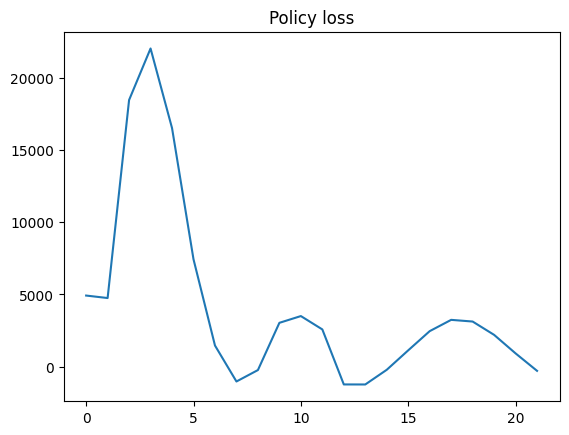

Iteration: 294 / 300, mean total cost 584317.0625, % change: -18.47


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.25it/s]


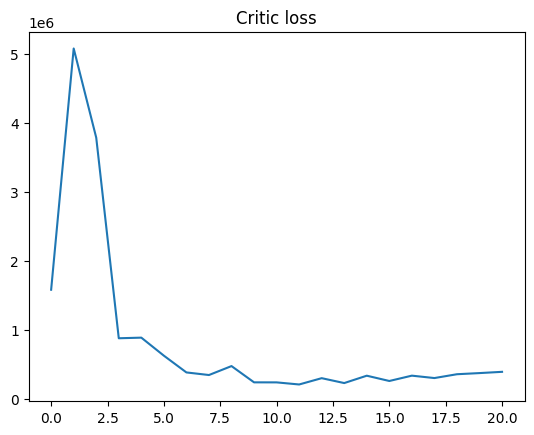

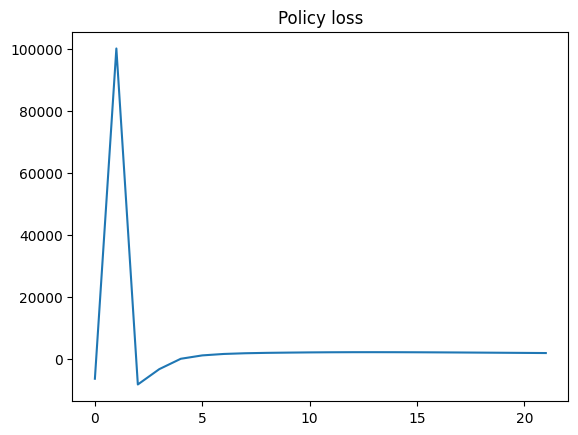

Iteration: 295 / 300, mean total cost 514547.40625, % change: -11.94


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.84it/s]


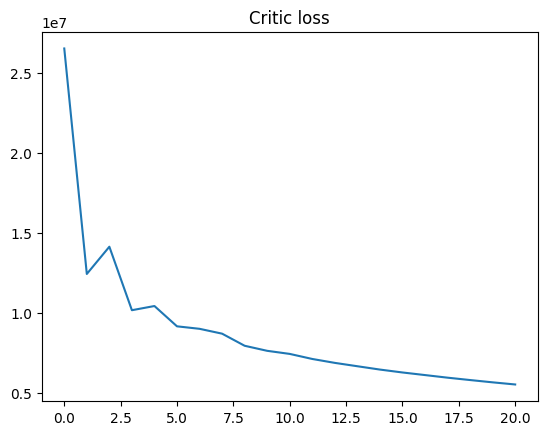

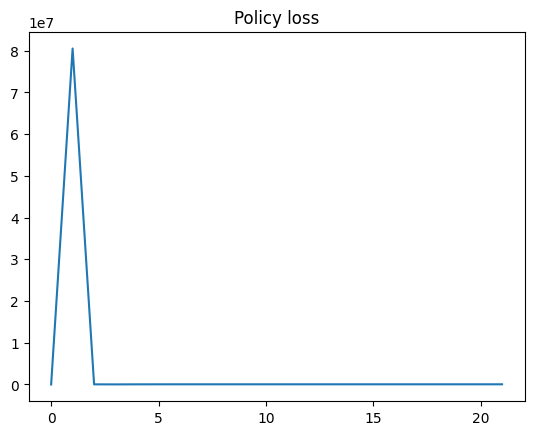

Iteration: 296 / 300, mean total cost 463850.625, % change: -9.85


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.71it/s]


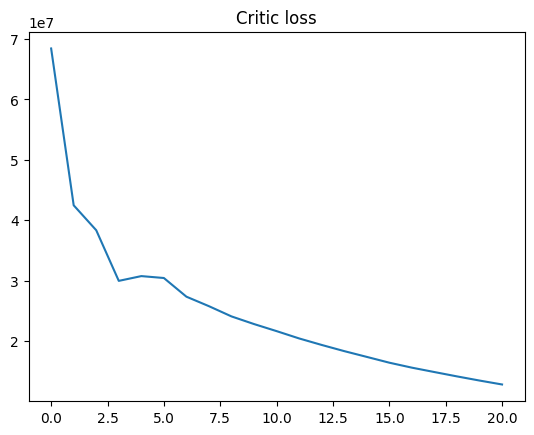

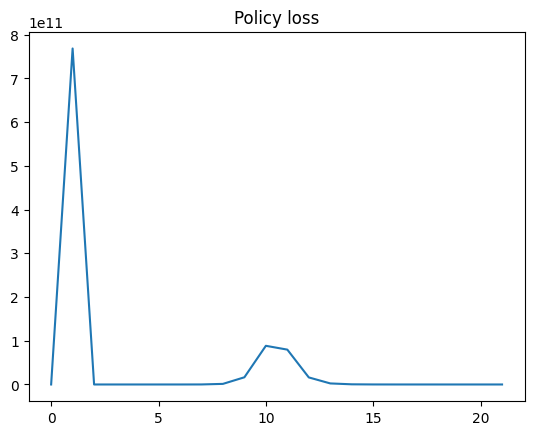

Iteration: 297 / 300, mean total cost 719750.0, % change: +55.17


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.04it/s]


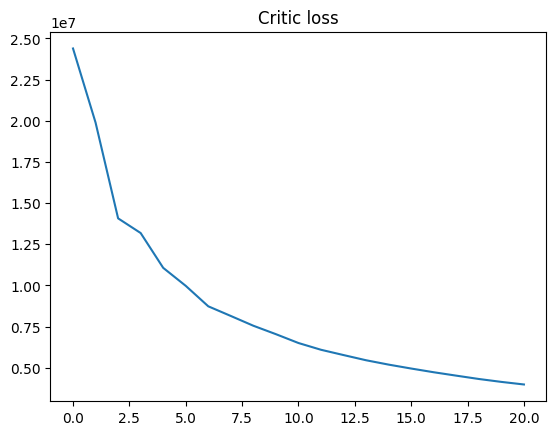

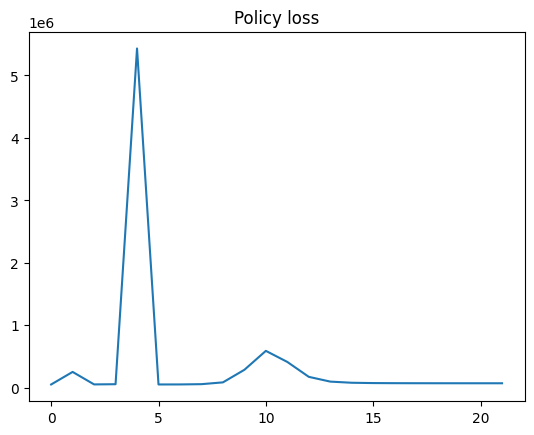

Iteration: 298 / 300, mean total cost 815440.0, % change: +13.29


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.98it/s]


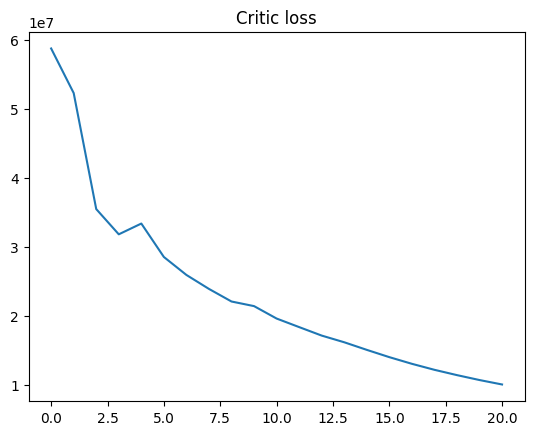

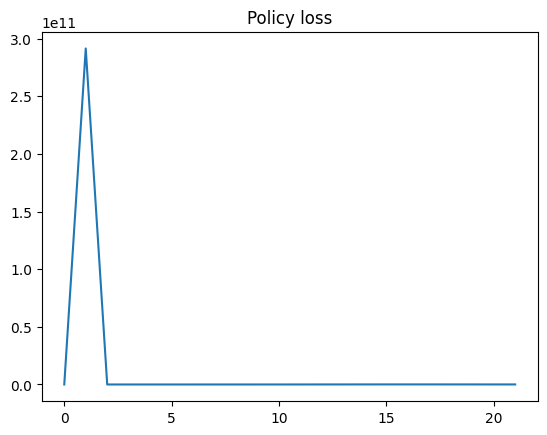

Iteration: 299 / 300, mean total cost 542097.1875, % change: -33.52


  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_13015/309398485.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.22it/s]


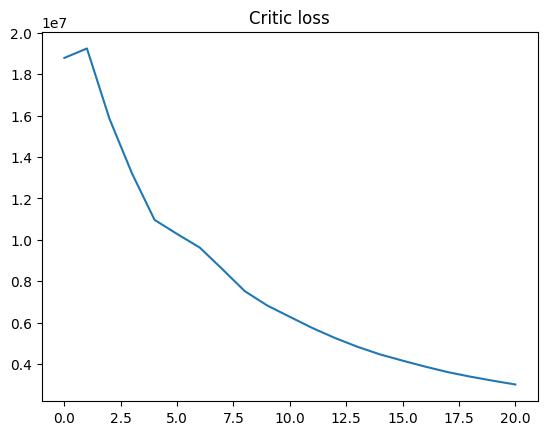

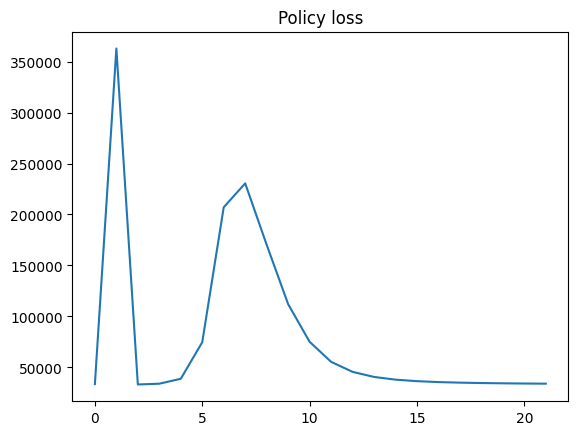

Iteration: 300 / 300, mean total cost 803853.9375, % change: +48.29


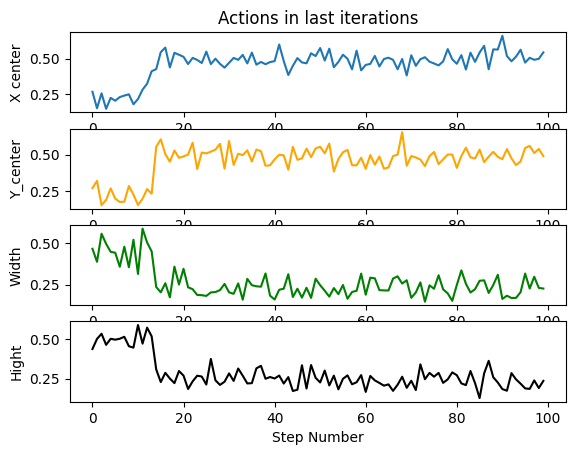

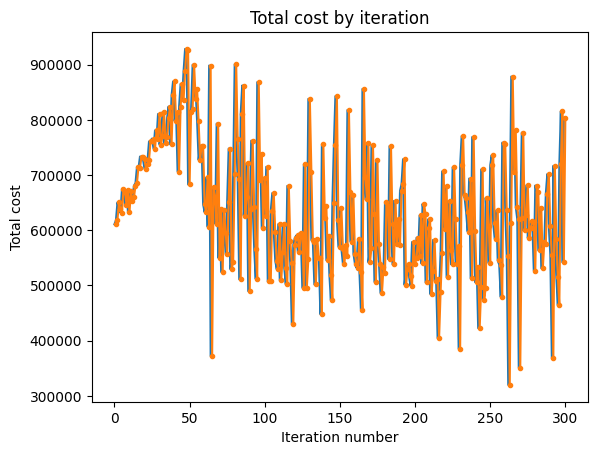

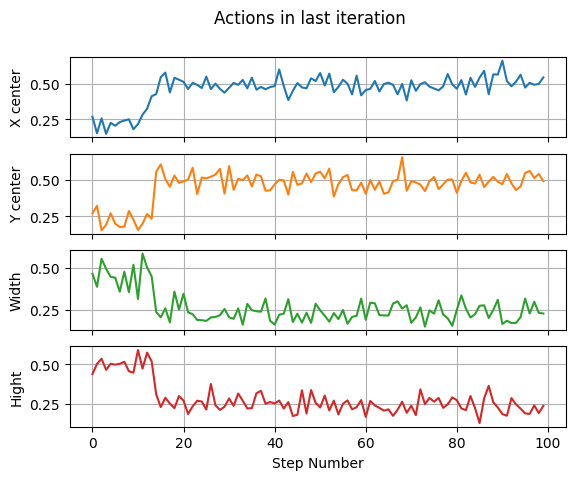

In [7]:
from sklearn.model_selection import ParameterGrid

# parameters = {"std": [0.2],
#              "critic_opt_lr": [0.00001, 0.0001],
#              "critic_opt_epoches": [20, 25],
#              "N_episodes": [4, 6],
#              "td_n": [2, 3],
#              "policy_opt_lr": [0.00001, 0.0001],
#              "policy_opt_epoches": [20, 25]
#              }

# parameters = {"std": [0.2],
#              "critic_opt_lr": [0.00001],
#              "critic_opt_epoches": [25, 30],
#              "N_episodes": [5, 6, 7],
#              "td_n": [2, 3],
#              "policy_opt_lr": [0.0001],
#              "policy_opt_epoches": [25, 30]
#              }

parameters = {"std": [0.1],
             "critic_opt_lr": [0.00012, 0.00011, 0.00013],
             "critic_opt_epoches": [19, 20, 21],
             "N_episodes": [6],
             "td_n": [2],
             "policy_opt_lr": [0.0001],
             "policy_opt_epoches": [22]
             }

param_grid = ParameterGrid(parameters)
gs_len = len(param_grid)
print(gs_len)
for i, param_set in enumerate(param_grid):
    # print(param_set)
    # if i in [0, 1, 2, 3, 4, 5]:
    #     continue
    # break
    ex_name = f'GSearch(9)_{i}/{gs_len}'
    try:
        run_param(ex_name, param_set)
    except:
        continue

In [40]:
game = PressGame()
game.step()
(observation, action, step_idx, cost) = game.get_sim_step_data()
print(action, step_idx, cost)

[0, 0, 0, 0] 1 tensor(0)


In [25]:
game.reset()

tensor([0.7604, 0.4371, 0.4987, 0.9750]) 1 tensor(11200)
tensor([-0.5000,  0.5000,  1.0000])
torch.Size([1, 16, 16])


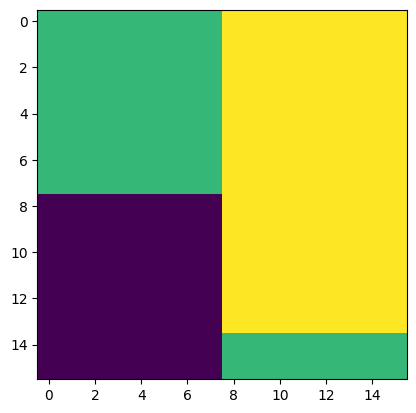

In [41]:
game.reset()
random_action = torch.rand(4)
# random_action = torch.tensor([0.25, 0.75, 0.6, 0.6])
game.receive_action(random_action)
game.step()
(observation, action, step_idx, cost) = game.get_sim_step_data()
print(action, step_idx, cost)
print(torch.unique(observation))
print(observation.shape)

plt.imshow(observation[0])
plt.show()
# plt.imshow(observation[1])
plt.show()

In [30]:
print(torch.unique(observation))

tensor([-0.5000,  0.5000])
